In [42]:
from IPython.display import clear_output

In [43]:
%pip install torch torchvision torchsummary
%pip install numpy
%pip install matplotlib

clear_output()

In [44]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Contents

In this notebook, we'll once again attempt to train an Auto Encoder model and generate images from it. The images we'll train on and generate are MNIST images (0-9 digits).
This time, we'll utilize the power of CNN instead of limiting ourselves to linear layers

You need to know:

1. **pytorch** (for impelementation)
2. a bit of **torch dataloaders and datasets** (not necessary but helps understanding how we're loading data)
3. A little bit of **matplotlib** (for result and training trajectory visualization)

In [45]:
batch_size = 64

train_transforms = transforms.Compose([
                        # transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

train_data = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [46]:
class CNNAutoEncoder(nn.Module):

  def __init__(self, encoding_dim=8):

    super().__init__()

    # self.econv1 = nn.Conv2d(1, 32, 3, 2, 1)
    # self.ebn1 = nn.BatchNorm2d(32)
    # self.econv2 = nn.Conv2d(32, 64, 3, 2, 1)
    # self.ebn2 = nn.BatchNorm2d(64)
    # self.elinear1 = nn.Linear(64*7*7, 100)
    # self.elinear2 = nn.Linear(100, encoding_dim)

    # self.dlinear1 = nn.Linear(encoding_dim, 100)
    # self.dlinear2 = nn.Linear(100,64*7*7)
    # self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding =1)
    # self.dconv2 = nn.ConvTranspose2d(32, 1, 3, 2, 1, output_padding =1)

    # self.relu = nn.ReLU()
    # self.sigmoid = nn.Sigmoid()


    self.encoder_block = nn.Sequential(
        nn.Conv2d(1,16,3,2,1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.Conv2d(16,32,3,2,1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(32,64,3,2,1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        nn.Linear(64 * 4 * 4, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, encoding_dim),
        nn.Tanh(),
    )

    self.decoder_linear = nn.Sequential(
        nn.Linear(encoding_dim, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 64 * 4 * 4),
        nn.BatchNorm1d(64 * 4 * 4),
        nn.LeakyReLU(),
    )

    self.decoder_cnn = nn.Sequential(
        nn.ConvTranspose2d(64 ,32, 3 , 2,1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32 ,16, 3 , 2,1 , output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(16 ,1, 3 , 2,1,1),
        nn.Sigmoid(),
    )

  def encoder(self, x):
    # Encoder forward pass

    # x = self.relu(self.econv1(x))
    # x = self.ebn1(x)
    # x = self.relu(self.econv2(x))
    # x = self.ebn2(x)
    # x = x.flatten(start_dim=1)
    # x = self.relu(self.elinear1(x))
    # x = self.sigmoid(self.elinear2(x))

    x = self.encoder_block(x)
    return x

  def decoder(self, x):
    # Decoder forward pass

    x = self.decoder_block(x)
    x = x.reshape((-1,64,4,4))
    x = self.decoder_block2(x)

    # x = self.relu(self.dlinear1(x))
    # x = self.relu(self.dlinear2(x))
    # x = x.view(-1, 64,7,7)
    # x = self.relu(self.dconv1(x))
    # x = self.dconv2(x)
    return x

  def forward(self, x: torch.Tensor):

    single_inp = x.ndim == 3.  # 3 dimensions mean [C, H, W] not [B, C, H, W] so the input is a single image not batch

    # since the layers expect a batch, let's add a 1 dimension to convert it to [1, C, H, W] where 1 becomes batch size
    if single_inp:
      x = x.unsqueeze(dim=0)

    encoder_out = self.encoder(x)
    decoder_out = self.decoder(encoder_out)

    # if the input was single images, the outputs should also be the same way for consistency
    if single_inp:
      encoder_out = encoder_out.squeeze(dim=0)
      decoder_out = decoder_out.squeeze(dim=0)

    return encoder_out, decoder_out

In [47]:
class CNNAutoEncoder(nn.Module):

  def __init__(self, encoding_dim=8):

    super().__init__()


    self.encoder_block = nn.Sequential(
        nn.Conv2d(1, 16, 3, 2, 1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.Conv2d(16, 32, 3, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(32, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Flatten(1, -1),
        nn.Linear(64 * 4 * 4, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, encoding_dim),
        nn.Tanh(),
    )

    self.decoder_linear = nn.Sequential(
        nn.Linear(encoding_dim, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 64 * 4 * 4),
        nn.BatchNorm1d(64 * 4 * 4),
        nn.LeakyReLU(),
    )

    self.decoder_cnn = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 3,2 ,1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
        nn.Sigmoid(),
    )

  def encoder(self, x):
    # Encoder forward pass

    x = self.encoder_block(x)
    return x

  def decoder(self, x):
    # Decoder forward pass

    x = self.decoder_linear(x)
    x = x.reshape((-1, 64, 4, 4))
    x = self.decoder_cnn(x)

    return x

  def forward(self, x: torch.Tensor):

    single_inp = x.ndim == 3.  # 3 dimensions mean [C, H, W] not [B, C, H, W] so the input is a single image not batch

    # since the layers expect a batch, let's add a 1 dimension to convert it to [1, C, H, W] where 1 becomes batch size
    if single_inp:
      x = x.unsqueeze(dim=0)

    encoder_out = self.encoder(x)
    decoder_out = self.decoder(encoder_out)

    # if the input was single images, the outputs should also be the same way for consistency
    if single_inp:
      encoder_out = encoder_out.squeeze(dim=0)
      decoder_out = decoder_out.squeeze(dim=0)

    return encoder_out, decoder_out

In [48]:
# encoding_dim = 128
encoding_dim = 4
model = CNNAutoEncoder(encoding_dim=encoding_dim)

In [49]:
with torch.no_grad():
  summary(model, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

# num_epochs = 9
# lr = 1e-2
num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [51]:
train_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  for (X, _) in train_loader:

    X = X.to(device)

    (encoder_outs, decoder_outs) = model(X)

    optimizer.zero_grad()
    loss = criterion(decoder_outs, X)
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += loss.item()*len(X)

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  print(f'epoch {i+1}/{num_epochs}, loss = {epoch_loss}')

  train_losses.append(epoch_loss)

epoch 1/20, loss = 0.1505068909406662
epoch 2/20, loss = 0.06774017689029375
epoch 3/20, loss = 0.04598790970047315
epoch 4/20, loss = 0.0386057939350605
epoch 5/20, loss = 0.03550447553396225
epoch 6/20, loss = 0.033837857290109
epoch 7/20, loss = 0.032912855656941735
epoch 8/20, loss = 0.03212194811006387
epoch 9/20, loss = 0.031691371405124666
epoch 10/20, loss = 0.03120781413714091
epoch 11/20, loss = 0.030938104989131292
epoch 12/20, loss = 0.0307004974146684
epoch 13/20, loss = 0.030321627513567605
epoch 14/20, loss = 0.0301349800268809
epoch 15/20, loss = 0.029957199158271153
epoch 16/20, loss = 0.029779089786609012
epoch 17/20, loss = 0.02962294877767563
epoch 18/20, loss = 0.029438917517662047
epoch 19/20, loss = 0.029310790197054546
epoch 20/20, loss = 0.02917481384277344


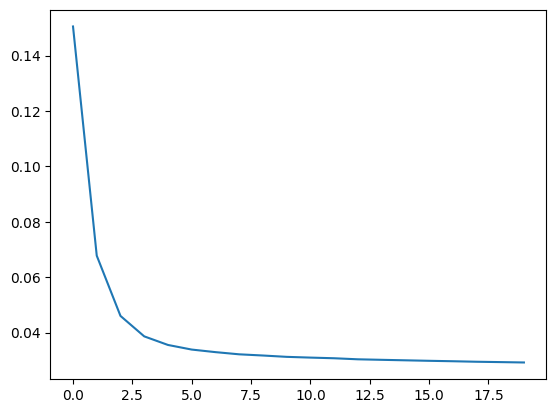

In [52]:
plt.plot(train_losses)

In [53]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

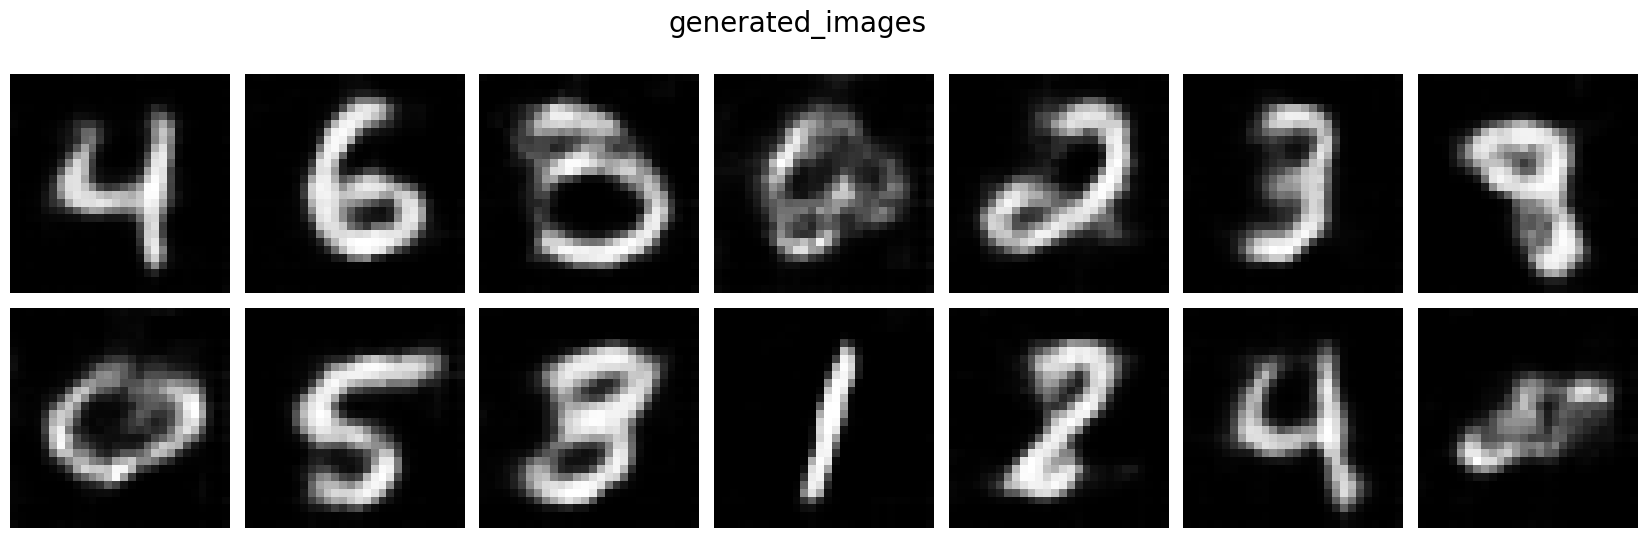

In [54]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7
sample_encodings = (torch.rand(rows*cols, encoding_dim).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
  generations = model.decoder(sample_encodings).cpu()
  generations = generations.reshape(-1, 28, 28, 1)
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")